In [25]:
import uproot
import awkward as ak
import numpy as np
import os

def compare_observables(
    file_groups: dict,
    tree_name: str = None,
    plot_dir: str = "./plots"
):
    """
    Compare observables across multiple datasets.

    Parameters:
    - file_groups: dict of {label: list_of_files}, where each list is a group of ROOT files
    - tree_name: optional override (mainly for MiniAOD)
    - plot_dir: directory to save plots
    """
    os.makedirs(plot_dir, exist_ok=True)
    data_by_label = {}

    # Load files under each label
    for label, files in file_groups.items():
        combined_data = {}

        for fp in files:
            with uproot.open(fp) as f:
                for tname in f.keys():
                    clean_key = tname.split(";")[0]
                    tree = f[clean_key]
                    arr = tree.arrays()

                    # Handle single-field trees (like NanoGEN observables)
                    flat_array = arr[""] if "" in arr.fields else arr

                    if clean_key not in combined_data:
                        combined_data[clean_key] = [flat_array]
                    else:
                        combined_data[clean_key].append(flat_array)

        # Final merge for the label
        data_by_label[label] = {k: ak.concatenate(v) for k, v in combined_data.items()}

    # Reference label and map
    base_label = list(data_by_label.keys())[0]
    base_data = data_by_label[base_label]

    B1 = ak.to_numpy(ak.flatten(base_data["gen_hel_B1"], axis=-1))
    B2 = ak.to_numpy(ak.flatten(base_data["gen_hel_B2"], axis=-1))
    C = ak.to_numpy(ak.flatten(base_data["gen_hel_C"], axis=-1))
    ll_cHel = ak.to_numpy(base_data["gen_ll_cHel"])

    observable_map = {
        'gen_b1k': B1[:, 0], 'gen_b2k': B2[:, 0],
        'gen_b1r': B1[:, 1], 'gen_b2r': B2[:, 1],
        'gen_b1n': B1[:, 2], 'gen_b2n': B2[:, 2],
        'gen_c_kk': C[:, 0, 0], 'gen_c_kr': C[:, 0, 1], 'gen_c_kn': C[:, 0, 2],
        'gen_c_rk': C[:, 1, 0], 'gen_c_rr': C[:, 1, 1], 'gen_c_rn': C[:, 1, 2],
        'gen_c_nk': C[:, 2, 0], 'gen_c_nr': C[:, 2, 1], 'gen_c_nn': C[:, 2, 2],
        'gen_ll_cHel': ll_cHel
    }

    # Build per-label observable dictionary
    observables_all = {}
    for label, data in data_by_label.items():
        if "gen_hel_B1" in data:
            b1 = ak.to_numpy(ak.flatten(data["gen_hel_B1"], axis=-1))
            b2 = ak.to_numpy(ak.flatten(data["gen_hel_B2"], axis=-1))
            c = ak.to_numpy(ak.flatten(data["gen_hel_C"], axis=-1))
            ll = ak.to_numpy(data["gen_ll_cHel"])

            observables_all[label] = {
                'gen_b1k': b1[:, 0], 'gen_b2k': b2[:, 0],
                'gen_b1r': b1[:, 1], 'gen_b2r': b2[:, 1],
                'gen_b1n': b1[:, 2], 'gen_b2n': b2[:, 2],
                'gen_c_kk': c[:, 0, 0], 'gen_c_kr': c[:, 0, 1], 'gen_c_kn': c[:, 0, 2],
                'gen_c_rk': c[:, 1, 0], 'gen_c_rr': c[:, 1, 1], 'gen_c_rn': c[:, 1, 2],
                'gen_c_nk': c[:, 2, 0], 'gen_c_nr': c[:, 2, 1], 'gen_c_nn': c[:, 2, 2],
                'gen_ll_cHel': ll
            }
        else:
            # Assume flat format (e.g., MiniAOD tree)
            observables_all[label] = {
                key: ak.to_numpy(data[key]) for key in observable_map
            }

    # Loop and plot
    for obs_name in observable_map:
        if any(obs_name not in observables_all[label] for label in observables_all):
            print(f"Skipping {obs_name}: not found in all datasets.")
            continue

        obs_dict = {}
        weights_dict = {}

        for label in observables_all:
            obs = observables_all[label][obs_name]
            obs_dict[label] = obs

            # Default: flat weight
            weight = np.ones_like(obs)

            # Special handling for Reweighted_SM
            if label == "NanoAod_ReweightedSM":
                event_weights_array = data_by_label[label].get("event_weight", None)
                if event_weights_array is not None:
                    event_weights_np = ak.to_numpy(event_weights_array)
                    if event_weights_np.ndim == 2 and event_weights_np.shape[1] > 200:
                        weight = event_weights_np[:, 200]
                    else:
                        print(f"⚠️ Warning: event_weight shape not as expected in {label}, using flat weights.")
                else:
                    print(f"⚠️ Warning: event_weight missing in {label}, using flat weights.")

            weights_dict[label] = weight

        plot_observables(
            obs_dict=obs_dict,
            weights=weights_dict,
            xlabel=obs_name,
            save_name=os.path.join(plot_dir, obs_name)
        )


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import mplhep
import os

plt.style.use(mplhep.style.CMS)


def plot_observables(obs_dict, weights, xlabel, save_name):
    import matplotlib.pyplot as plt
    import numpy as np
    import mplhep

    fig, (ax, ax_ratio) = plt.subplots(
        2, 1,
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True,
        figsize=(10, 8)
    )

    colors = ['black', 'red', 'blue', 'green']
    reference_label = list(obs_dict.keys())[0]
    reference_counts = None
    reference_errors = None
    bin_edges = None
    global_max = 0

    for i, label in enumerate(obs_dict):
        obs = obs_dict[label]
        weight = weights[label]

        # Bin edges (consistent for all histograms)
        bins = np.histogram_bin_edges(obs, bins=6)

        counts, _ = np.histogram(obs, bins=bins, weights=weight, density=True)
        sumw, _ = np.histogram(obs, bins=bins, weights=weight)
        sumw2, _ = np.histogram(obs, bins=bins, weights=np.square(weight))

        bin_widths = np.diff(bins)
        errors = np.sqrt(sumw2) / (sumw * bin_widths)
        errors = np.nan_to_num(errors, nan=0.0, posinf=0.0, neginf=0.0)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        global_max = max(global_max, np.max(counts + errors))

        # Step histogram including final step
        ax.step(bins, np.append(counts, counts[-1]), where='post',
                color=colors[i % len(colors)], linewidth=2, label=label)
        
        # Vertical lines to close the steps
        ax.vlines(bins[0], 0, counts[0], color=colors[i % len(colors)], linewidth=2)
        ax.vlines(bins[-1], 0, counts[-1], color=colors[i % len(colors)], linewidth=2)
        
        # Error bars
        ax.errorbar(
            bin_centers, counts, yerr=errors,
            fmt='o', color=colors[i % len(colors)],
            markersize=4, capsize=2
        )

        if i == 0:
            reference_counts = counts
            reference_errors = errors
            bin_edges = bins
        else:
            ratio = np.divide(
                counts,
                reference_counts,
                out=np.zeros_like(counts),
                where=reference_counts != 0
            )
            rel_err_ref = np.divide(
                reference_errors,
                reference_counts,
                out=np.zeros_like(reference_errors),
                where=reference_counts != 0
            )
            rel_err = np.divide(
                errors,
                counts,
                out=np.zeros_like(errors),
                where=counts != 0
            )
            ratio_err = ratio * np.sqrt(rel_err**2 + rel_err_ref**2)

            # Step and error bar in ratio
            ax_ratio.step(
                bin_edges, np.append(ratio, ratio[-1]),
                where='post',
                color=colors[i % len(colors)]
            )

            ax_ratio.errorbar(
                bin_centers, ratio, yerr=ratio_err,
                fmt='o', color=colors[i % len(colors)],
                markersize=4, capsize=2
            )

    # Add vertical lines at bin edges
    for edge in [bin_edges[0], bin_edges[-1]]:
        ax.axvline(edge, color='gray', linestyle=':', linewidth=1)
        ax_ratio.axvline(edge, color='gray', linestyle=':', linewidth=1)

    # Labels and formatting
    ax.set_ylabel("Normalized Events")
    ax.set_ylim(0, 1.1 * global_max)
    ax.legend(loc='best')
    mplhep.cms.label("Work in progress", data=True, ax=ax, loc=0)

    ax_ratio.set_xlabel(xlabel)
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.axhline(1, color='gray', linestyle='--')
    ax_ratio.set_ylim(0.95, 1.05)
    ax_ratio.legend().remove()  # Hide ratio legend

    plt.tight_layout()
    plt.savefig(f"{save_name}.png")
    plt.show()



In [33]:
nanogen_ttbar=[
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_powheg_ttbar_dileptonic.root"
    ]
#nanogen_eft_central=[
        #"/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_central_sample_dileptonic.root",
        #"/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_central_sample_dileptonic.root",
        #"/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_central_sample_dileptonic.root"
    #]
nanogen_noeft=[
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_noEFT_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_noEFT_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_noEFT_dileptonic.root"
]

/tmp/ipykernel_9932/618706414.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_ratio.legend().remove()  # Hide ratio legend


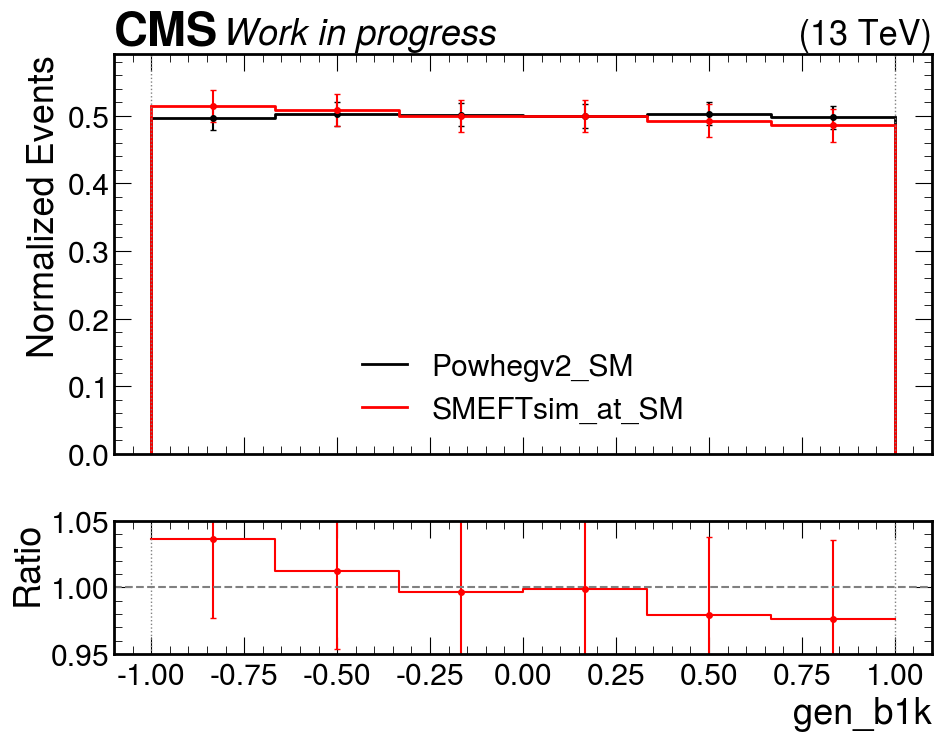

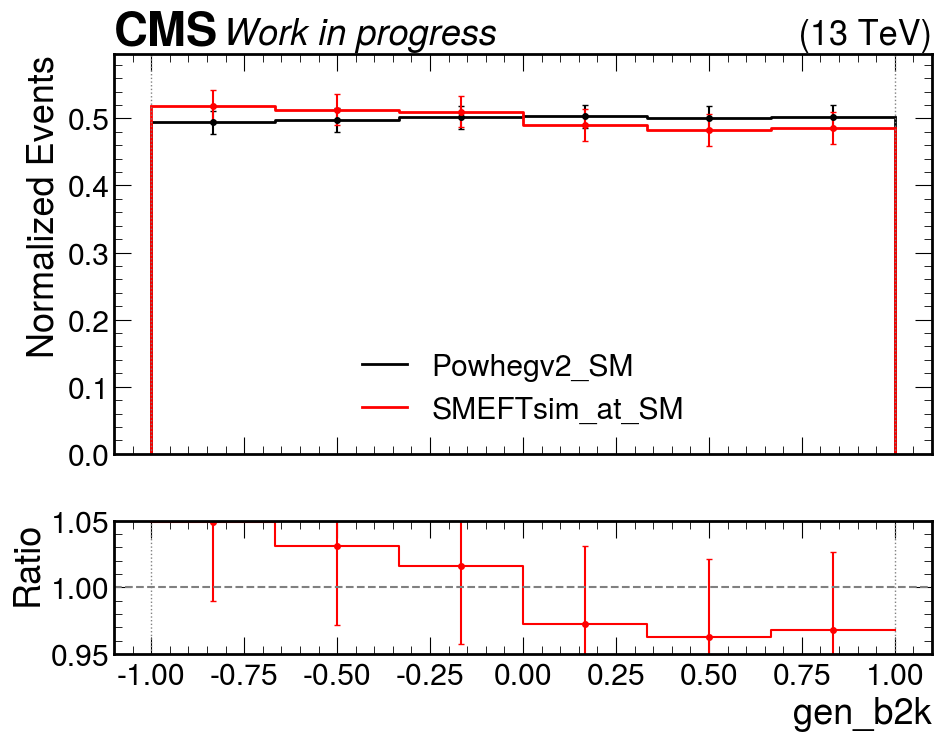

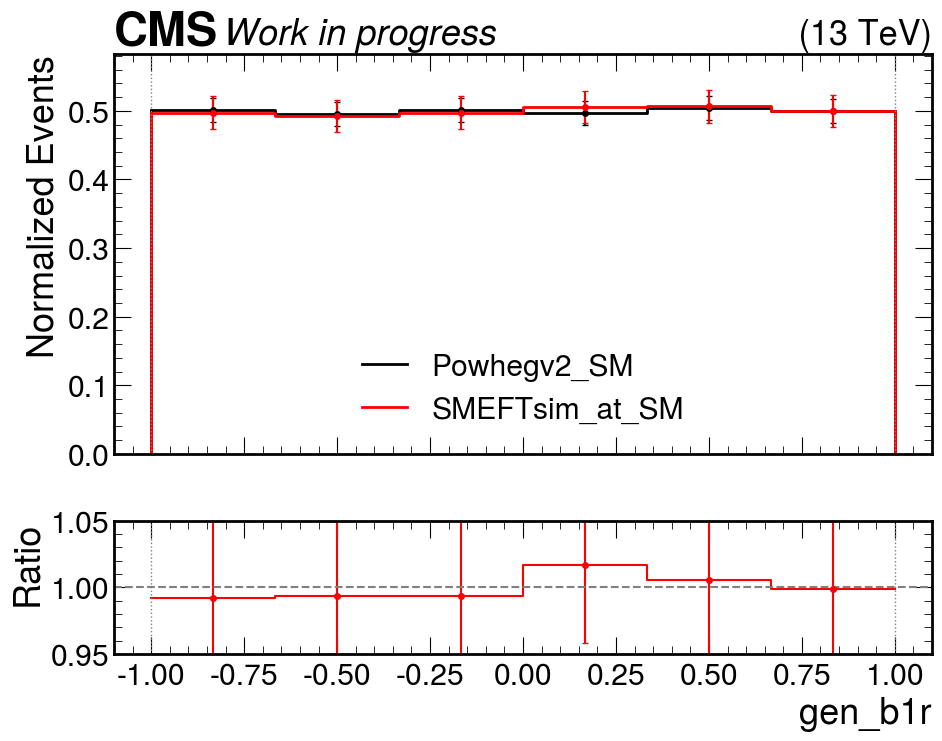

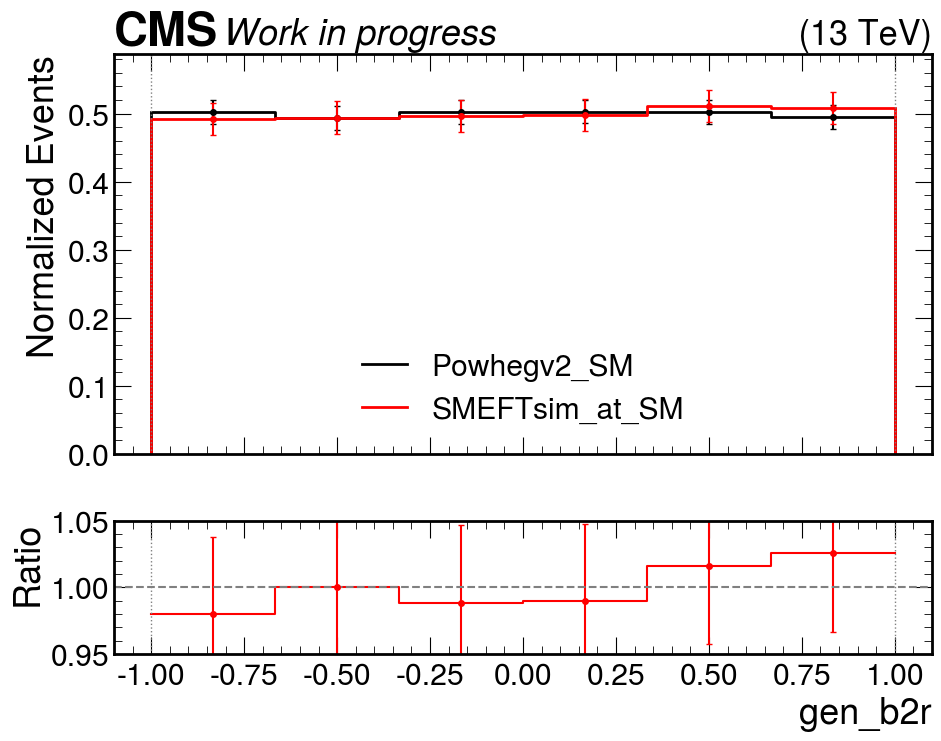

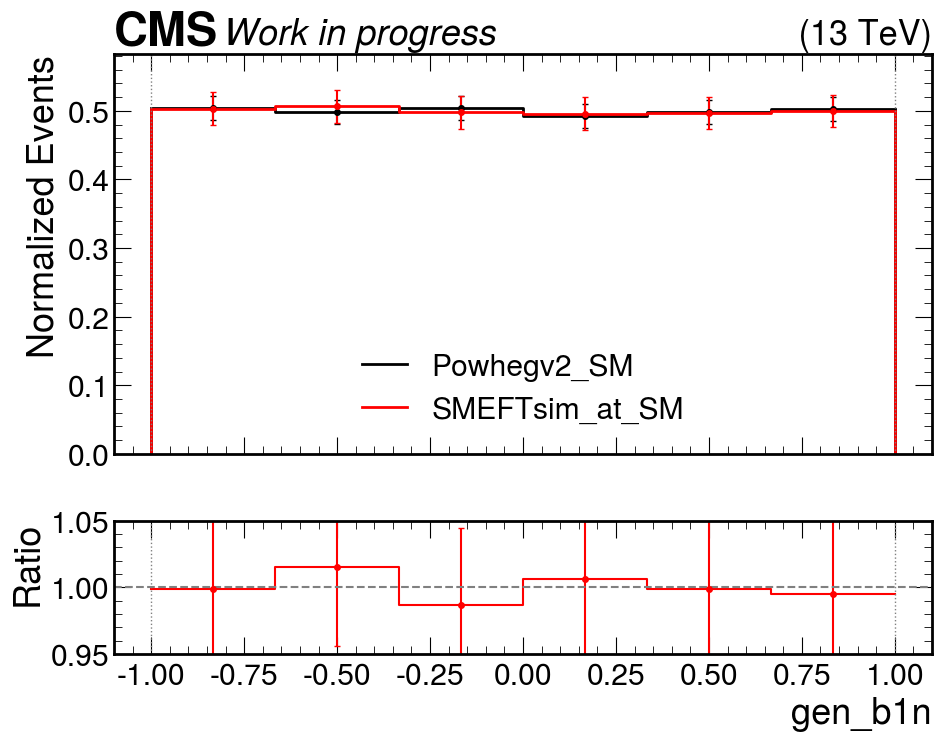

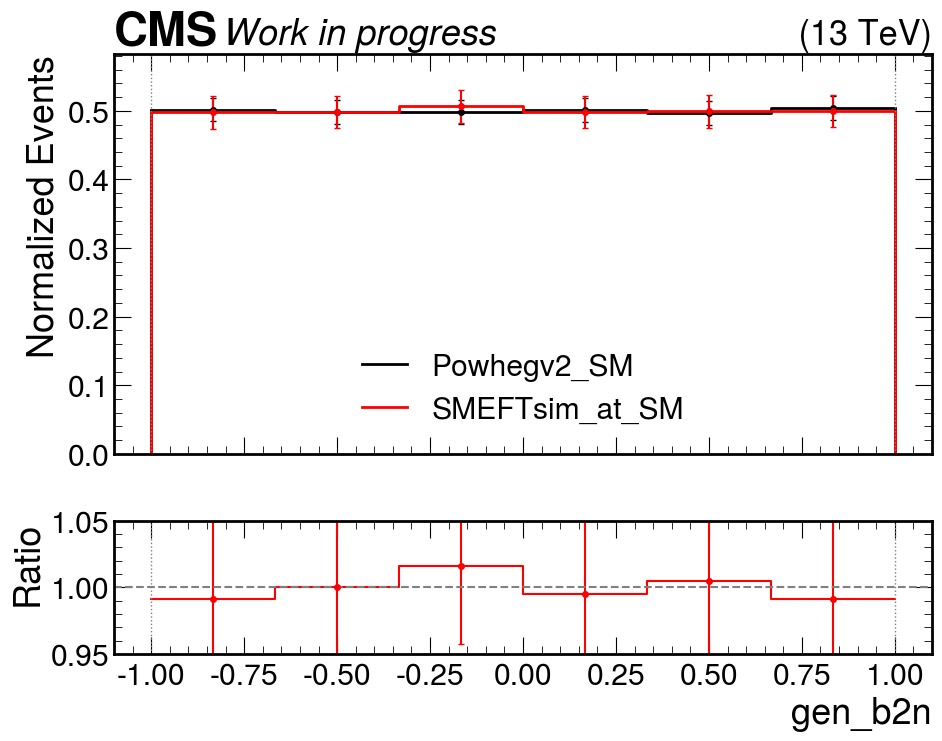

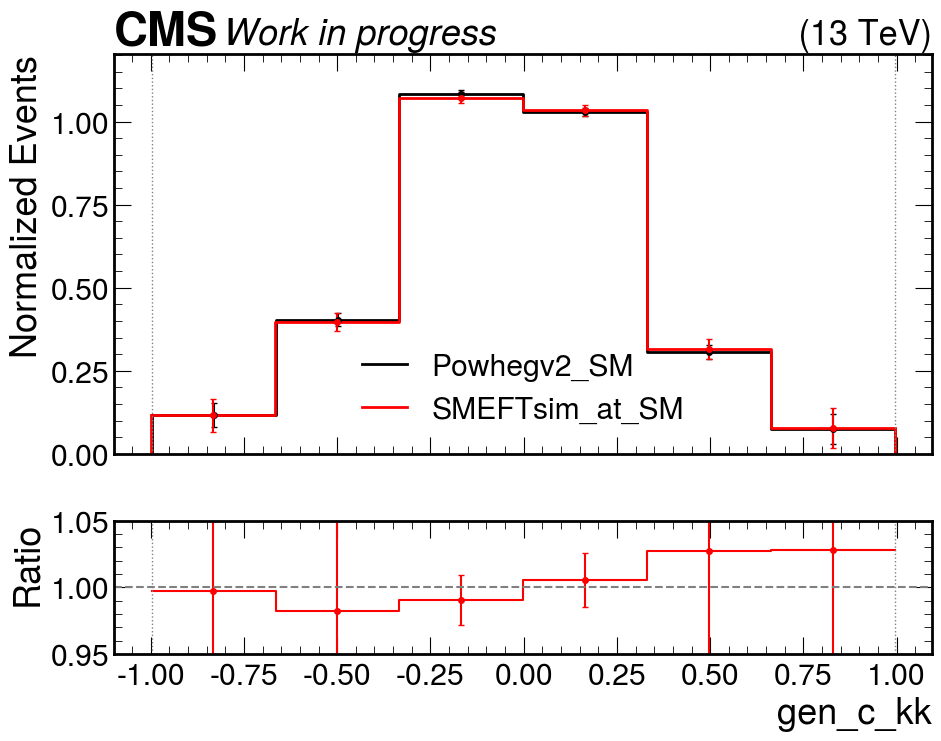

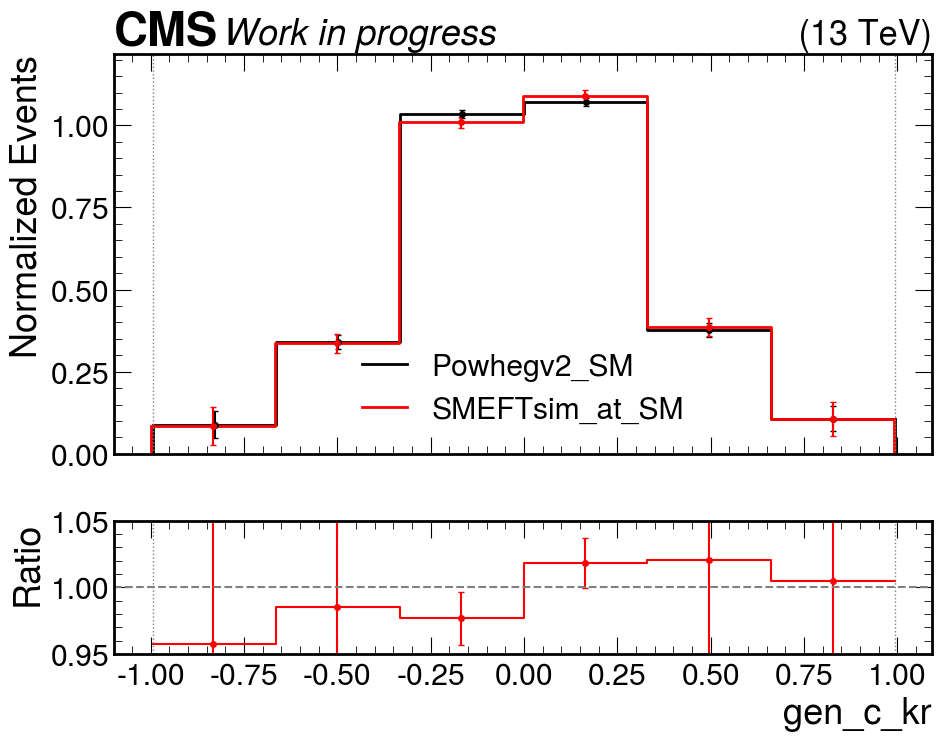

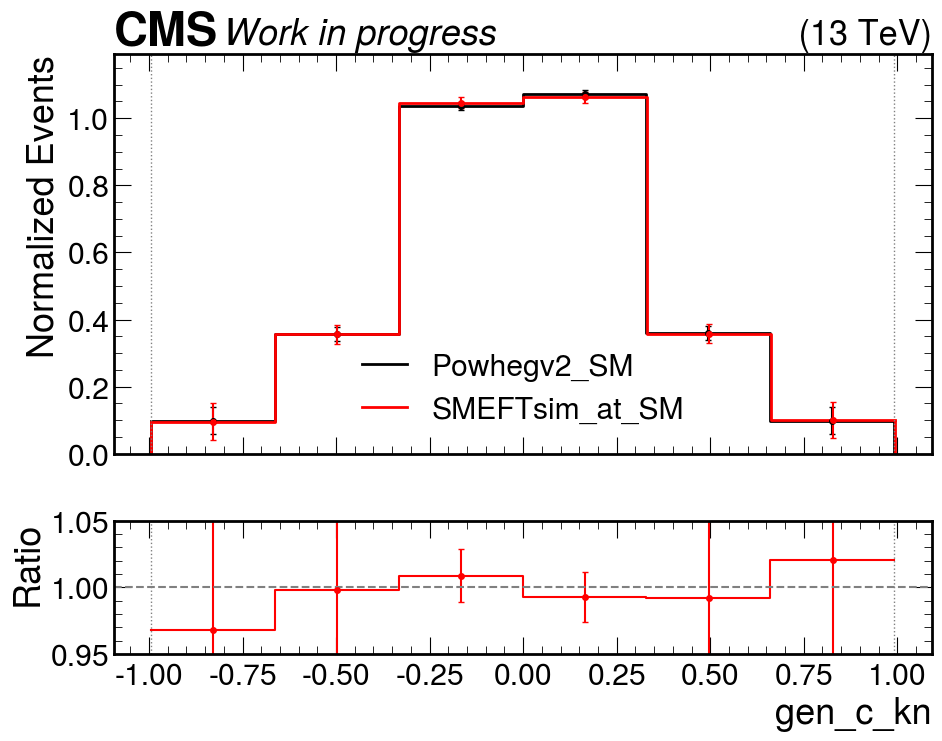

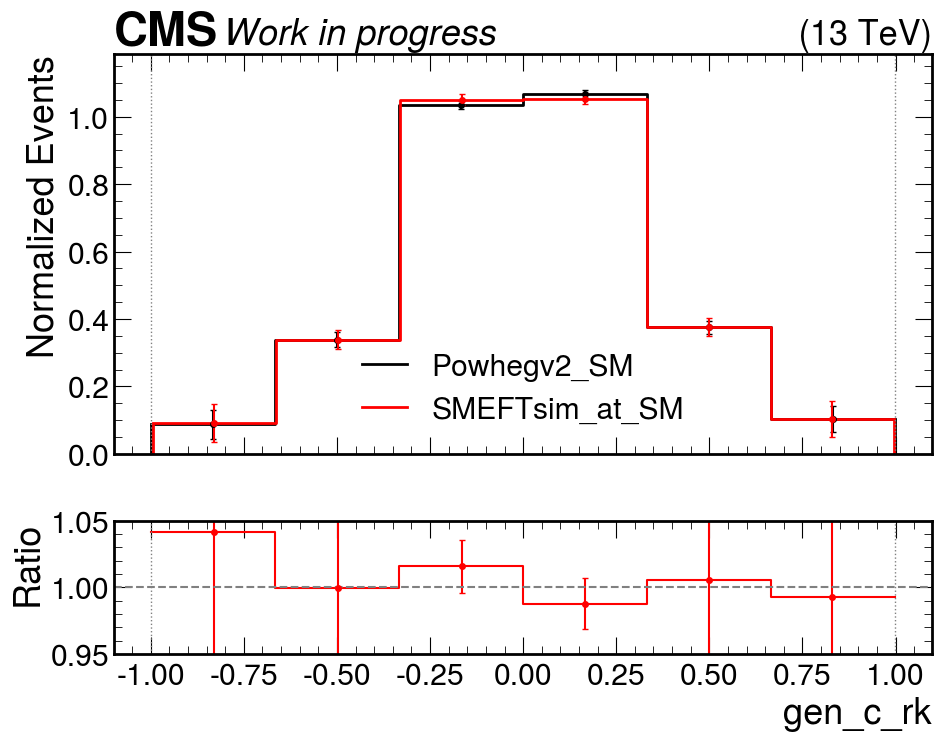

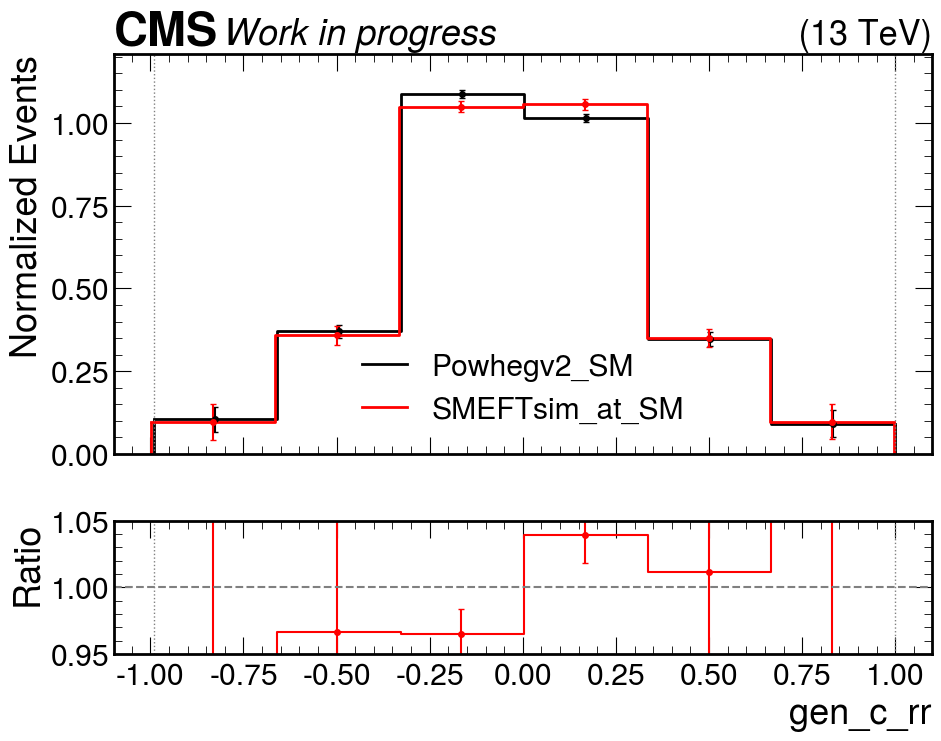

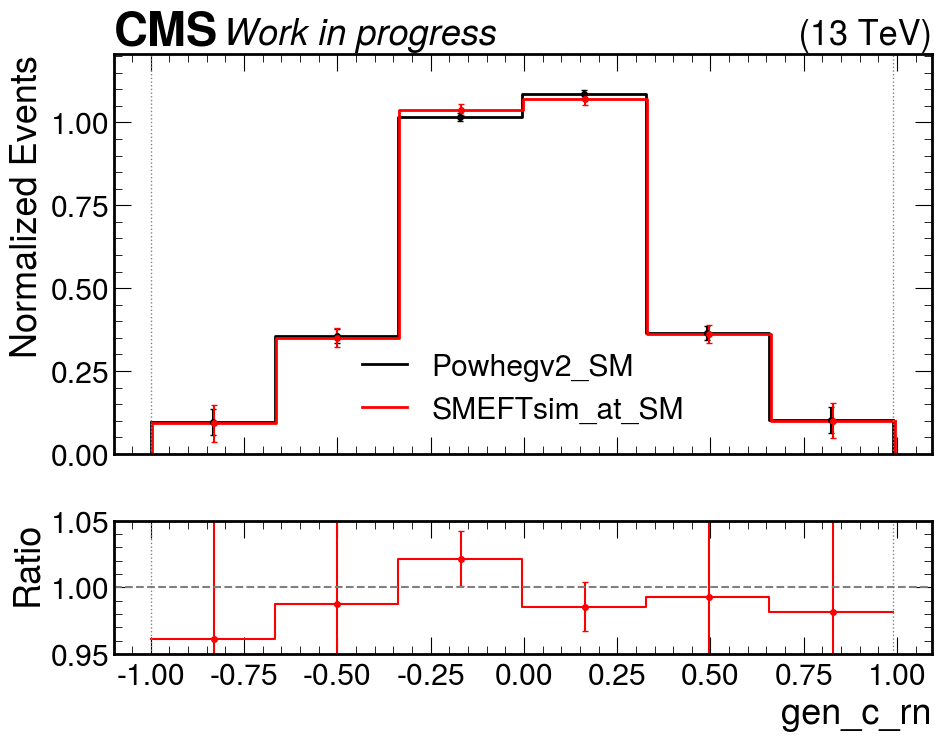

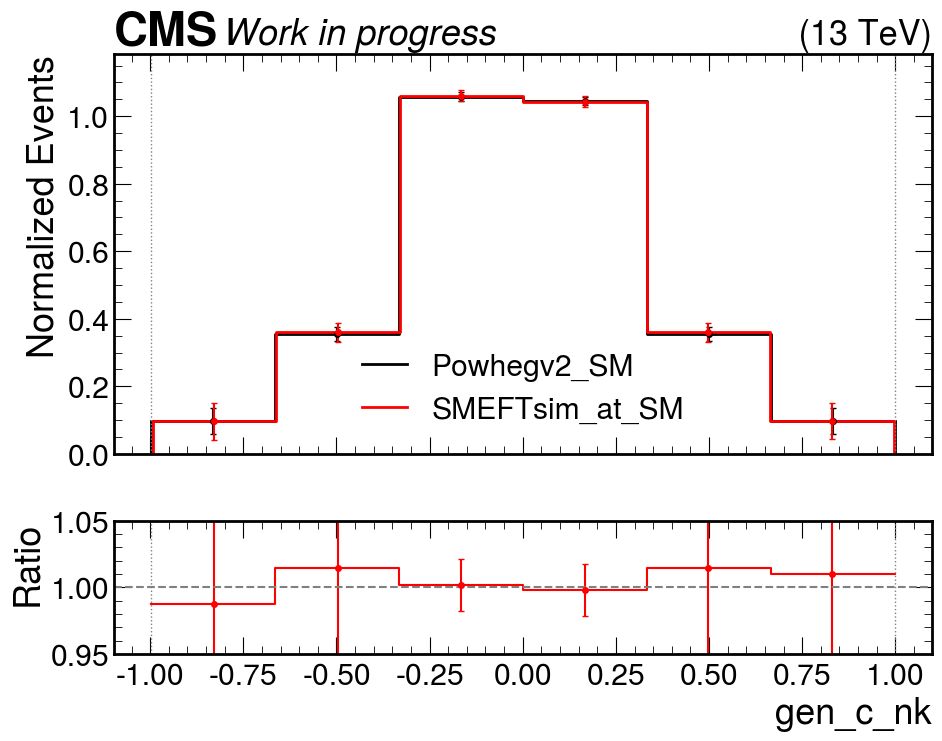

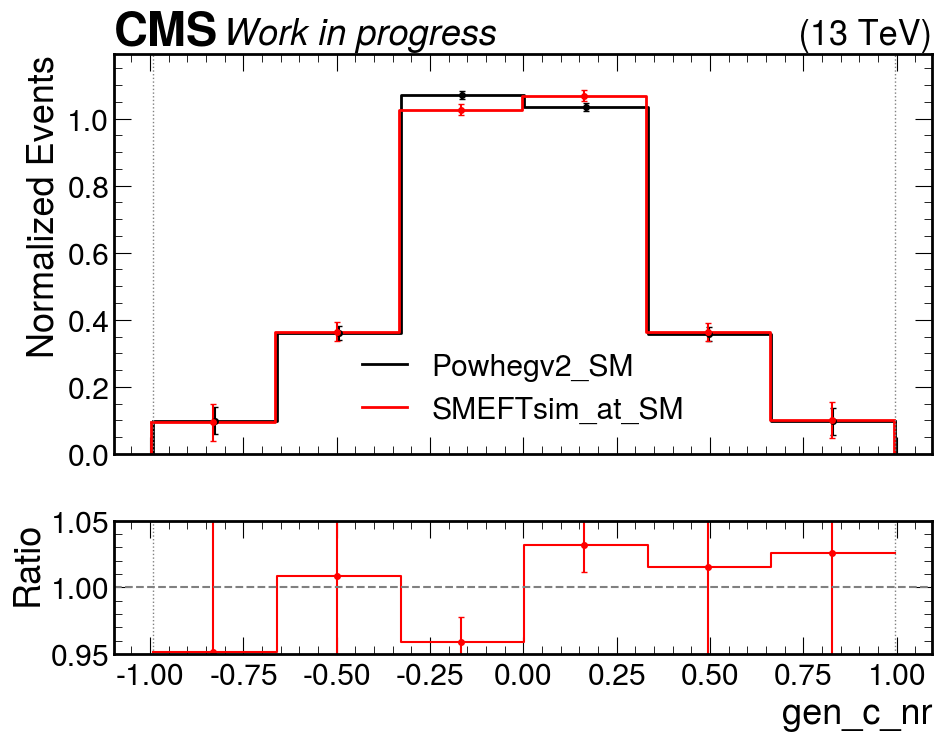

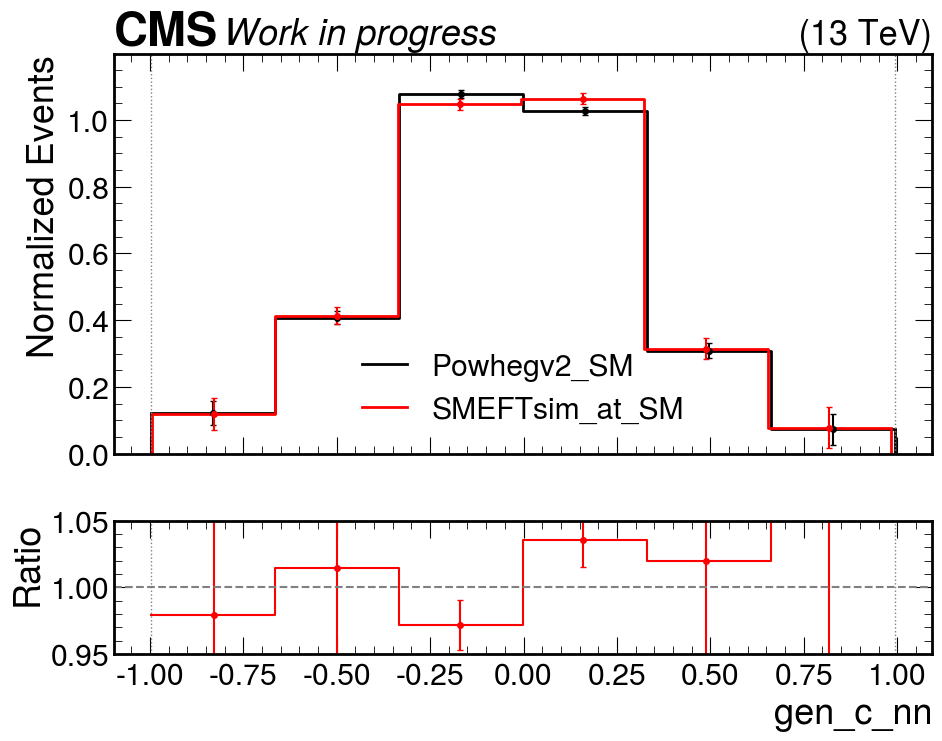

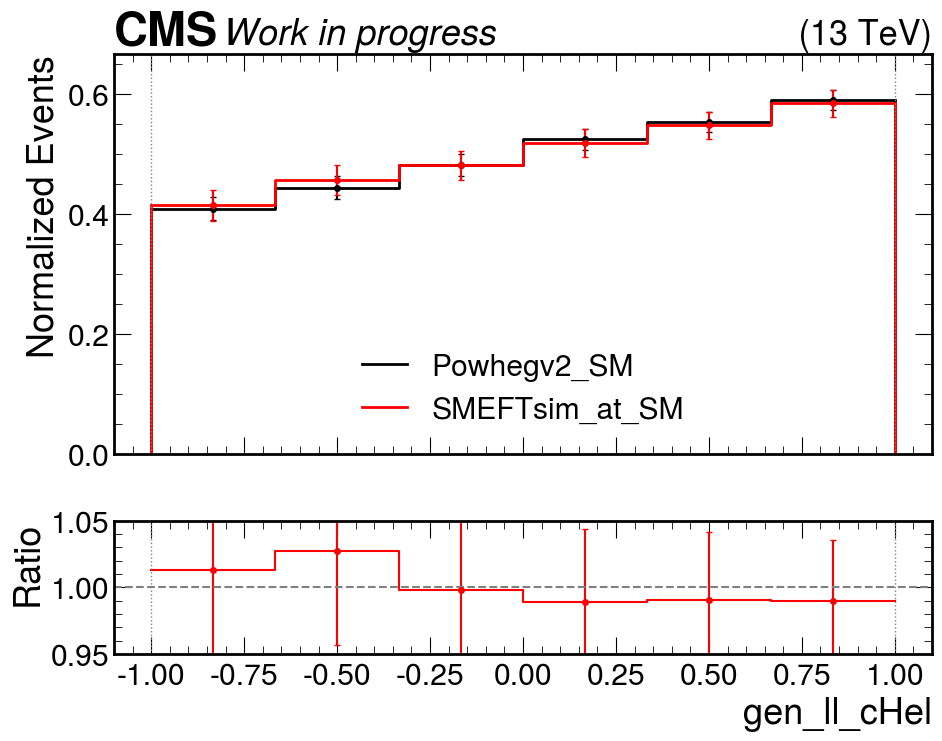

In [34]:
file_groups = {
    "Powhegv2_SM":nanogen_ttbar ,
    "SMEFTsim_at_SM":nanogen_noeft
}

compare_observables(
    file_groups=file_groups,
    plot_dir="/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Plot_nanogenttbar_vs_noEFT/"
)
